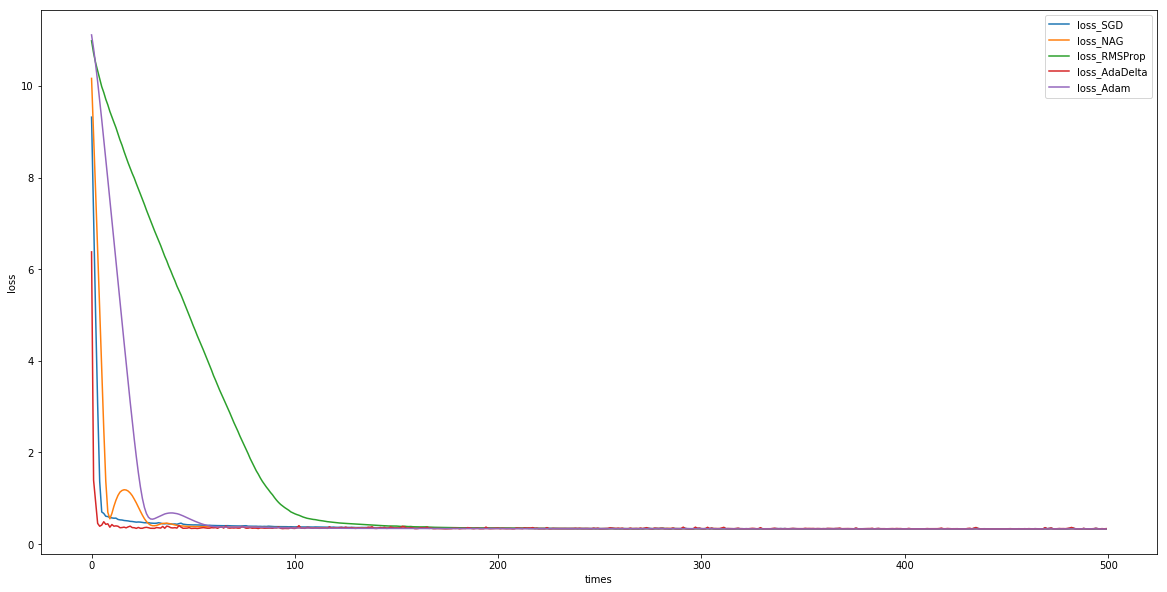

0.8484736809778269
0.8498249493274369
0.8504391622136233
0.8487807874209201
0.8498249493274369


In [3]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
mem = Memory("./mycache")

@mem.cache
def get_data(path):
    data = load_svmlight_file(path)
    return data[0], data[1]

import numpy as np
import matplotlib.pyplot as plt

X_train, y_train= get_data("a9a.txt")
X_test,y_test= get_data("a9a.t")
X_train = X_train.toarray()
X_test = X_test.toarray()
y_train[y_train==-1]=0
y_test[y_test==-1]=0
X_train=np.hstack((X_train,np.ones((X_train.shape[0],1))))#add a coloum of 1 after X_train
y_train = y_train.reshape((y_train.shape[0],1))
X_test=np.hstack((X_test,np.zeros((X_test.shape[0],1))))#add a coloum of 0 after X_test
X_test=np.hstack((X_test,np.ones((X_test.shape[0],1))))#add a coloum of 1 after X_test
y_test = y_test.reshape((y_test.shape[0],1))
one_test=np.ones((X_test.shape[0],1))


w=np.ones((X_train.shape[1],1)) #initialize the w
w1=np.ones((X_train.shape[1],1)) #initialize the w1
w2=np.ones((X_train.shape[1],1)) #initialize the w2
w3=np.ones((X_train.shape[1],1)) #initialize the w3
w4=np.ones((X_train.shape[1],1)) #initialize the w4
P=0 #initialize the right rate of SGD
P1=0 #initialize the right rate of NAG
P2=0 #initialize the right rate of RMSProp
P3=0 #initialize the right rate of AdaDelta
P4=0 #initialize the right rate of Adam
num=500 #times
loss_test_SGD=np.zeros((num)) #the loss of SGD
loss_test_NAG=np.zeros((num))
loss_test_RMSProp=np.zeros((num))
loss_test_AdaDelta=np.zeros((num))
loss_test_Adam=np.zeros((num))

def h(x,W):
    return np.exp(x.dot(W))

def sample(x,y,n): #select the random sample
    index_sample=np.random.randint(0,x.shape[0]-1,n)
    x_sample=np.zeros((n,x.shape[1]))
    y_sample=np.zeros((n,y.shape[1]))
    index=0
    for i in index_sample:
        x_sample[index]=x[i]
        y_sample[index]=y[i]
        index=index+1
    return x_sample,y_sample

def right_rate(W): #compute the right rate
    p=X_test.dot(W)
    right=0
    for i in range(X_test.shape[0]):
        if p[i]>=0:
            p[i]=1
        else:
            p[i]=0
        if p[i]==y_test[i]:
            right=right+1
    P=right/X_test.shape[0]
    return P

#SGD parameter
rate=0.5 #learning rate

#NAG parameter
v=0.1
gama_NAG=0.9
rate_NAG=0.05

#RMSProp parameter
gama_RMSProp=0.9
rate_RMSProp=0.01
epsilon_RMSProp=0.00000001
G_RMSProp=0

#AdaDelta parameter
G_AdaDelta=0
gama_AdaDelta=0.95
delta=0.01
epsilon_AdaDelta=0.00000001

#Adam parameter
G_Adam=0
beta=0.9
gama_Adam=0.999
rate_Adam=0.02
epsilon_Adam=0.00000001
m=0

for i in range(num):
    X_sample,y_sample=sample(X_train,y_train,64) #select the random sample set
    one_sample=np.ones((X_sample.shape[0],1))
    #SGD
    J=X_sample.T.dot((h(X_sample,w)/(one_sample+h(X_sample,w))-y_sample))/X_sample.shape[0] #the gradient
    w-=rate*J #update the w
    loss_test_SGD[i]=(one_test.T.dot((np.log(one_test+h(X_test,w))-X_test.dot(w)*y_test)))/X_test.shape[0] #compute the loss of SGD
    if right_rate(w)>P: #select the max right rate
        P=right_rate(w)
    
    #NAG
    J1=X_sample.T.dot((h(X_sample,w1)/(one_sample+h(X_sample,w1))-y_sample))/X_sample.shape[0]
    g_NAG=J1-gama_NAG*v
    v=gama_NAG*v+rate_NAG*g_NAG
    w1=w1-v
    loss_test_NAG[i]=(one_test.T.dot((np.log(one_test+h(X_test,w1))-X_test.dot(w1)*y_test)))/X_test.shape[0]
    if right_rate(w1)>P1:
        P1=right_rate(w1)
    
    #RMSProp
    J2=X_sample.T.dot((h(X_sample,w2)/(one_sample+h(X_sample,w2))-y_sample))/X_sample.shape[0]
    g_RMSProp=J2
    G_RMSProp=gama_RMSProp*G_RMSProp+(1-gama_RMSProp)*g_RMSProp*g_RMSProp
    w2-=rate_RMSProp/(np.sqrt(G_RMSProp+epsilon_RMSProp))*g_RMSProp
    loss_test_RMSProp[i]=(one_test.T.dot((np.log(one_test+h(X_test,w2))-X_test.dot(w2)*y_test)))/X_test.shape[0]
    if right_rate(w2)>P2:
        P2=right_rate(w2)
    
    #AdaDelta
    J3=X_sample.T.dot((h(X_sample,w3)/(one_sample+h(X_sample,w3))-y_sample))/X_sample.shape[0]
    g_AdaDelta=J3
    G_AdaDelta=gama_AdaDelta*G_AdaDelta+(1-gama_AdaDelta)*g_AdaDelta*g_AdaDelta
    delta_Q=-(np.sqrt(delta+epsilon_AdaDelta)/np.sqrt(G_AdaDelta+epsilon_AdaDelta))*g_AdaDelta
    w3+=delta_Q
    delta=gama_AdaDelta*delta+(1-gama_AdaDelta)*delta_Q*delta_Q
    loss_test_AdaDelta[i]=(one_test.T.dot((np.log(one_test+h(X_test,w3))-X_test.dot(w3)*y_test)))/X_test.shape[0]
    if right_rate(w3)>P3:
        P3=right_rate(w3)
    
    #Adam
    J4=X_sample.T.dot((h(X_sample,w4)/(one_sample+h(X_sample,w4))-y_sample))/X_sample.shape[0]
    g_Adam=J4
    m=beta*m+(1-beta)*g_Adam
    G_Adam=gama_Adam*G_Adam+(1-gama_Adam)*g_Adam*g_Adam
    alpha=rate_Adam*(np.sqrt(1-gama_Adam)/(1-beta))
    w4-=alpha*(m/np.sqrt(G_Adam+epsilon_Adam))
    loss_test_Adam[i]=(one_test.T.dot((np.log(one_test+h(X_test,w4))-X_test.dot(w4)*y_test)))/X_test.shape[0]
    if right_rate(w4)>P4:
        P4=right_rate(w4)
    
i =range(num)
#Draw graphs of Ltrain and Ltest with the number of iterations
plt.rcParams['figure.figsize']= (20,10)
plt.plot(i,loss_test_SGD,label = 'loss_SGD')
plt.plot(i,loss_test_NAG,label = 'loss_NAG')
plt.plot(i,loss_test_RMSProp,label = 'loss_RMSProp')
plt.plot(i,loss_test_AdaDelta,label = 'loss_AdaDelta')
plt.plot(i,loss_test_Adam,label = 'loss_Adam')
plt.legend(loc='upper right')
plt.xlabel('times')
plt.ylabel('loss')
plt.show()


print(P) #print the right rate of SGD
print(P1) #print the right rate of NAG
print(P2) #print the right rate of RMSProp
print(P3) #print the right rate of AdaDelta
print(P4) #print the right rate of Adam